In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
from hmmlearn.hmm import GaussianHMM
import numpy as np

# Đọc dữ liệu
file_path = "jena_climate_2009_2016.csv"
df = pd.read_csv(file_path)

# Đổi định dạng cột thời gian và đặt làm index
df['Date Time'] = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')
df.set_index('Date Time', inplace=True)

# Sắp xếp lại index để dùng slicing theo thời gian
df.sort_index(inplace=True)

# Lọc cột nhiệt độ
df = df[['T (degC)']]

C:\Users\admin\AppData\Local\Temp\ipykernel_21052\828523818.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.resample('1H').mean()


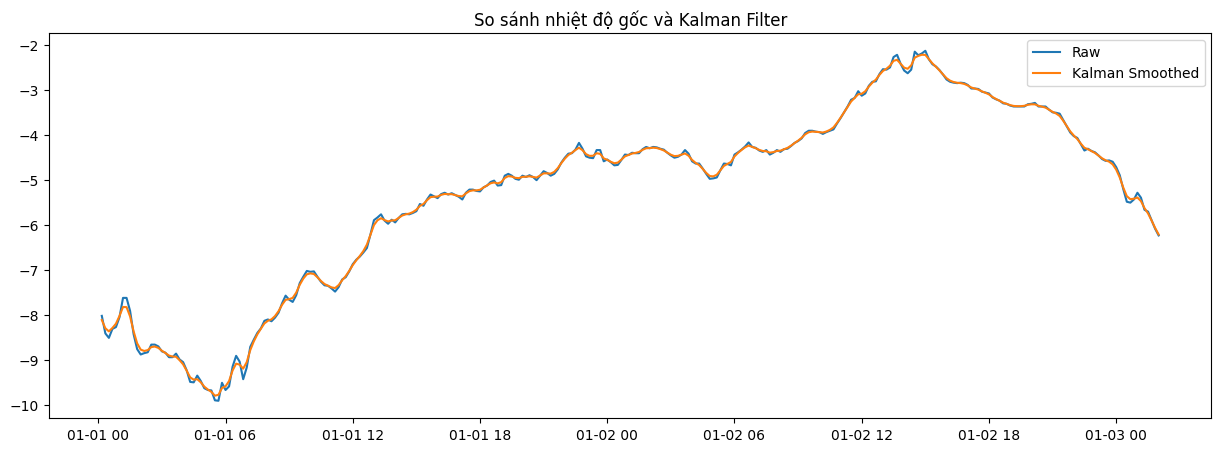

In [19]:
# Khởi tạo Kalman Filter đơn giản
kf = KalmanFilter(initial_state_mean=temperature[0], n_dim_obs=1)
state_means, _ = kf.smooth(temperature)

# Lưu vào dataframe mới
df['Temp_Kalman'] = state_means

# Chuyển sang dạng hourly và daily (multi-resolution)
df_hourly = df.resample('1H').mean()
df_daily = df.resample('1D').mean()

# Vẽ nhiệt độ gốc vs mượt hóa
plt.figure(figsize=(15, 5))
plt.plot(df['T (degC)'][:300], label='Raw')
plt.plot(df['Temp_Kalman'][:300], label='Kalman Smoothed')
plt.legend()
plt.title("So sánh nhiệt độ gốc và Kalman Filter")
plt.show()

In [21]:
# Tầng 2: Huấn luyện HMM theo ngày (macro-state)
daily_data = df_daily['Temp_Kalman'].dropna()
X2 = daily_data.values.reshape(-1, 1)
model_day = GaussianHMM(n_components=3, covariance_type="diag", n_iter=1000).fit(X2)
states_day = model_day.predict(X2)
df_daily.loc[daily_data.index, 'State'] = states_day

# Tầng 1: Huấn luyện HMM theo giờ với thông tin từ tầng ngày
hourly_data = df_hourly['Temp_Kalman'].dropna()
df_hourly = df_hourly.loc[hourly_data.index]  # đảm bảo chỉ làm việc với dữ liệu không NaN

# Tạo cột trạng thái ngày tương ứng cho từng dòng theo giờ
date_to_macro_state = dict(zip(daily_data.index.date, states_day))
macro_states_for_hour = df_hourly.index.date
macro_states_mapped = [date_to_macro_state.get(d, -1) for d in macro_states_for_hour]

# Huấn luyện từng mô hình HMM theo từng macro state
df_hourly['Macro_State'] = macro_states_mapped
df_hourly['Micro_State'] = np.nan  # khởi tạo

for macro_state in np.unique(states_day):
    sub_df = df_hourly[df_hourly['Macro_State'] == macro_state]
    if len(sub_df) < 10:
        continue  # quá ít dữ liệu để huấn luyện

    X_sub = sub_df['Temp_Kalman'].values.reshape(-1, 1)
    model_micro = GaussianHMM(n_components=3, covariance_type="diag", n_iter=1000).fit(X_sub)
    micro_states = model_micro.predict(X_sub)
    df_hourly.loc[sub_df.index, 'Micro_State'] = micro_states

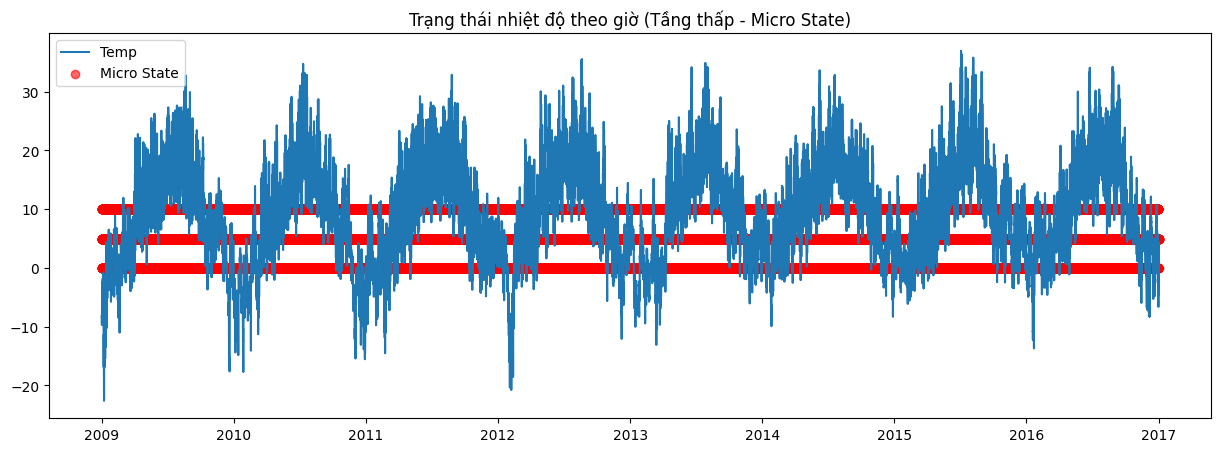

In [ ]:
# Trực quan hóa trạng thái nhiệt độ theo giờ
plt.figure(figsize=(15, 5))
plt.plot(df_hourly.index, df_hourly['Temp_Kalman'], label='Temp')
plt.scatter(df_hourly.index, df_hourly['Micro_State'] * 5, c='red', label='Micro State', alpha=0.6)
plt.legend()
plt.title("Trạng thái nhiệt độ theo giờ (Tầng thấp - Micro State)")
plt.show()

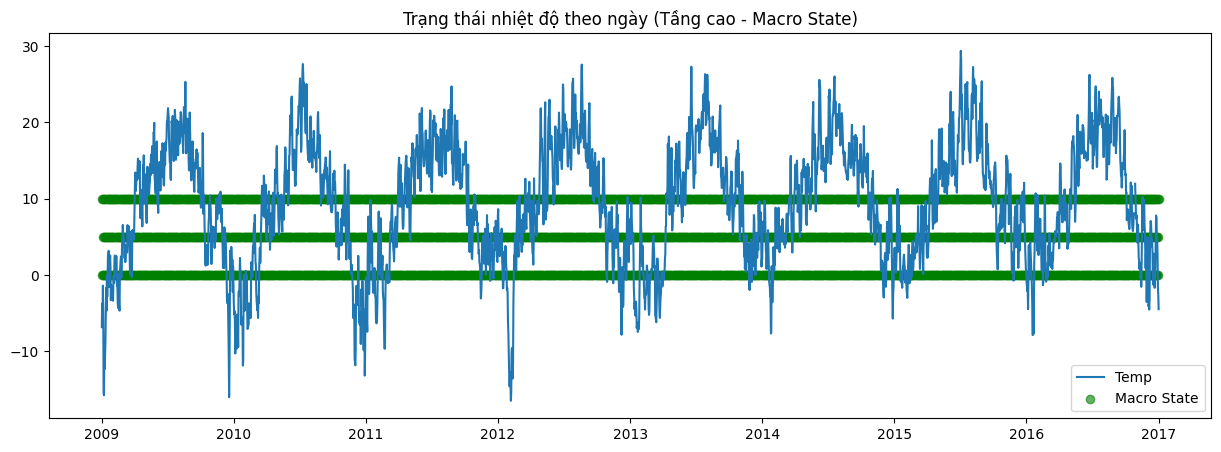

In [ ]:
# Trực quan hóa trạng thái nhiệt độ theo ngày
plt.figure(figsize=(15, 5))
plt.plot(df_daily.index, df_daily['Temp_Kalman'], label='Temp')
plt.scatter(df_daily.index, df_daily['State'] * 5, c='green', label='Macro State', alpha=0.6)
plt.legend()
plt.title("Trạng thái nhiệt độ theo ngày (Tầng cao - Macro State)")
plt.show()